In [1]:
import sys
sys.path.append('..')
sys.path.append('/Users/jh7685/Documents/Projects/pysurfer')
from pysurfer.mgz_helper import map_values_as_mgz
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
from scipy.stats import f_oneway
import warnings
from itertools import product
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
#freesurfer_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'

# Load beta values

In [3]:
subj='subj01'
hemi='lh'
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', f'{subj}', 'nativesurface', 'nsdsyntheticbetas_fithrf_GLMdenoise_RR', f'{hemi}.betas_nsdsynthetic.hdf5')
design_mat=os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
task_keys=['fixation_task','memory_task']
stim_info=os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
task_average=True
eccentricity_path= os.path.join(nsd_dir, 'nsddata', 'freesurfer', f'{subj}', 'label',  f'{hemi}.prfeccentricity.mgz')

In [4]:
betas_df = sfm.get_whole_brain_betas(betas_path=betas, design_mat_path=design_mat,
                          stim_info_path=stim_info,
                          task_keys=task_keys, task_average=task_average, eccentricity_path=eccentricity_path,
                          x_axis='voxel', y_axis='stim_idx', long_format=True)

In [5]:
betas_df.head()

,stim_idx,image_idx,names,w_r,w_a,phase,class_idx,freq_lvl,voxel,task,betas,eccentricity,local_sf
0,0,104,pinwheel,0.0,6.0,0.000000,0,0,0,avg,1.321667,1.370705,0.696670
1,1,105,pinwheel,0.0,6.0,1.570796,0,0,0,avg,2.753333,1.370705,0.696670
2,2,106,pinwheel,0.0,6.0,3.141593,0,0,0,avg,1.098333,1.370705,0.696670
3,3,107,pinwheel,0.0,6.0,4.712389,0,0,0,avg,1.440000,1.370705,0.696670
4,4,108,pinwheel,0.0,11.0,0.000000,1,1,0,avg,1.675000,1.370705,1.277229


In [6]:
betas_df = betas_df.query('~names.str.contains("intermediate").values')
avg_betas_df = betas_df.groupby(['voxel', 'freq_lvl']).mean().reset_index()

In [43]:
loss_history

,epoch,loss
0,0,0.604097
1,1,0.603213
2,2,0.602330
3,3,0.601445
4,4,0.600561
...,...,...
9995,9995,0.013667
9996,9996,0.013667
9997,9997,0.013666
9998,9998,0.013666


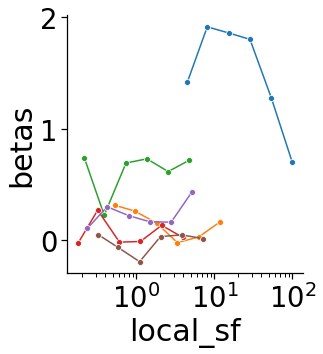

In [8]:
vis1D.plot_curves_sns(avg_betas_df.query('voxel in @random_voxels'),
                      x='local_sf', y='betas',
                      hue='voxel',col=None, to_logscale=True)

In [40]:
test = avg_betas_df.query('voxel < 10')[['voxel','local_sf', 'betas']]
test.query('voxel == @v')

,voxel,local_sf,betas
6,1,0.730276,0.945208
7,1,1.309308,1.236771
8,1,2.493320,1.297708
9,1,4.621502,0.960833
10,1,8.663972,1.255000
11,1,16.081284,0.364896


In [41]:
for v in test.voxel.unique().tolist():
    tmp = test.query('voxel == @v')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    loss_history, model_history = tuning.fit_tuning_curves(my_model, my_dataset,
                                                       learning_rate=0.001,
                                                       max_epoch=10000,
                                                       print_every=10000,
                                                       save_path=None)


**epoch no.0 loss: 1.26141 

**epoch no.9999 loss: 0.05851 

**epoch no.10000: Finished! final model params...
 {'slope': 1.677, 'mode': 2.206, 'sigma': 2.317}

Elapsed time: 3.88 sec 

**epoch no.0 loss: 1.10025 

**epoch no.9999 loss: 0.03702 

**epoch no.10000: Finished! final model params...
 {'slope': 1.295, 'mode': 2.375, 'sigma': 2.164}

Elapsed time: 3.72 sec 

**epoch no.0 loss: 0.26834 

**epoch no.9999 loss: 0.0183 

**epoch no.10000: Finished! final model params...
 {'slope': 0.915, 'mode': 2.76, 'sigma': 1.878}

Elapsed time: 3.74 sec 

**epoch no.0 loss: 0.83567 

**epoch no.9999 loss: 0.04406 

**epoch no.10000: Finished! final model params...
 {'slope': 1.485, 'mode': 2.261, 'sigma': 2.294}

Elapsed time: 3.72 sec 

**epoch no.0 loss: 1.21107 

**epoch no.9999 loss: 0.03256 

**epoch no.10000: Finished! final model params...
 {'slope': 1.39, 'mode': 2.369, 'sigma': 2.232}

Elapsed time: 3.71 sec 

**epoch no.0 loss: 0.57655 

**epoch no.9999 loss: 0.02018 

**epoch no.1

In [132]:
n_bins=10
print(avg_betas_df['voxel'].max())
ww = avg_betas_df['voxel'].nunique()
print(ww)
step = np.floor(ww/n_bins).astype(int)
print(step)
np.arange(0, avg_betas_df['voxel'].nunique(), step)


227020
227021
22702


array([     0,  22702,  45404,  68106,  90808, 113510, 136212, 158914,
       181616, 204318, 227020])

In [137]:
n_bins = 10
avg_betas_df['bins'], step = sfm.divide_df_into_n_bins(avg_betas_df, 'voxel', 10, return_step=True)
print(step)
n = 0
for i in range(10):
    tmp = avg_betas_df[avg_betas_df['bins'] == 8]
    n += tmp.voxel.nunique()
print(n)

22702
227020


# Plot loss history to see convergence

In [78]:
hemi='rh'
subj_list = [utils.sub_number_to_string(sn, dataset='nsdsyn') for sn in np.arange(1,9)]
f = [f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_anova/voxel-tuning/train_history/nsdsyn/loss-history_voxel-test100_hemi-{hemi}_sub-{subj}.hdf' for subj in subj_list]
args = ['sub', 'hemi']
loss_history_df = utils.load_history_files(f, *args)

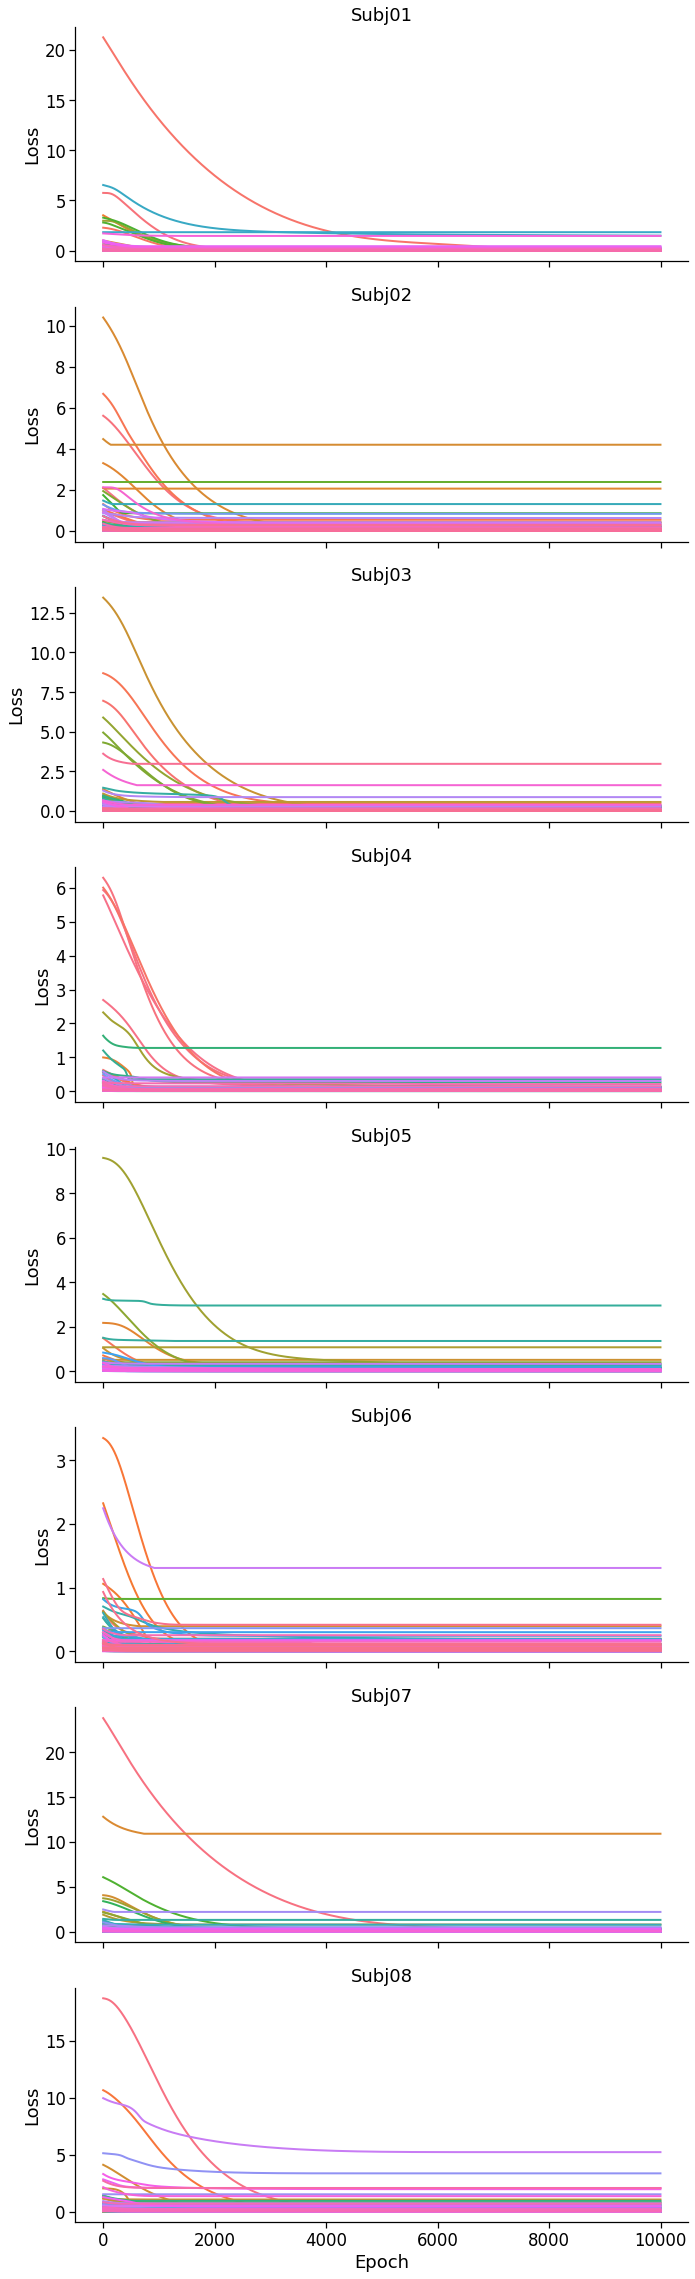

In [84]:
vis.plot_loss_history(loss_history_df,
                      hue='voxel',
                      col='sub', log_y=False, sharey=False, ci=None,
                      )